In [1]:
%matplotlib inline

from __future__ import division, print_function

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import SHS_data
import util
import paired_data

reload(paired_data);

## Learning cover song fingerprints

### Load some data

In [2]:
ratio = (50,20,30)
clique_dict, _ = SHS_data.read_cliques()
train_cliques, test_cliques, _ = util.split_train_test_validation(clique_dict, ratio=ratio)

print('Preloading chroma...')
train_uris = util.uris_from_clique_dict(train_cliques)
chroma_dict = SHS_data.preload_chroma(train_uris)

print('Collecting training dataset...')
n_patches, patch_len = 8, 64
X_A, X_B, is_cover, pair_uris = paired_data.dataset_of_pairs(train_cliques, chroma_dict,
                                                             n_patches=n_patches, patch_len=patch_len)
Y = is_cover.astype(float)
Y = Y.reshape((-1,1))

print(X_A.shape, X_B.shape, Y.shape)

Preloading chroma...
(32436, 512, 12) (32436, 512, 12) (32436, 1)


### Batch generators

In [3]:
def get_random_batch(cols, batch_size=50):
    ind = np.random.randint(0, len(cols[-1]), batch_size)
    return [col[ind] for col in cols]

def get_batches(arrays, batch_size=50):
    """Batch generator, no shuffling.
    
    Args:
        arrays (list): list of arrays. Arrays should have equal length
        batch_size (int): number of examples per batch
        
    Yields:
        list: list of batches of length batch_size
        
    Usage:
    >>> batches = get_batches([X, Y], batch_size=50)
    >>> x, y = batches.next()
    """
    array_lengths = [len(array) for array in arrays]
    n_examples = array_lengths[0]
    if not np.all(np.array(array_lengths) == n_examples):
        raise ValueError('Arrays must have the same length.')
    start = 0
    while True:
        start = np.mod(start, n_examples)
        stop = start + batch_size
        batch = [np.take(array, range(start, stop), axis=0, mode='wrap') for array in arrays]
        start = stop
        yield batch
        
# # test
# x = np.arange(100)
# y = x + 1988
# batches = get_batches([x, y], batch_size=7)
# for i in range(20):
#     print(next(batches))

### Tensorflow shorthands

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [5]:
def conv_bins(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def conv_frames(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_4x1(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 1, 1],
                        strides=[1, 4, 1, 1], padding='SAME')

def max_pool_8x1(x):
    return tf.nn.max_pool(x, ksize=[1, 8, 1, 1],
                        strides=[1, 8, 1, 1], padding='SAME')

def max_pool_16x1(x):
    return tf.nn.max_pool(x, ksize=[1, 16, 1, 1],
                        strides=[1, 16, 1, 1], padding='SAME')

### Network

#### input

In [6]:
input_len = n_patches * patch_len

x_A = tf.placeholder("float", shape=[None, input_len, 12])
x_B = tf.placeholder("float", shape=[None, input_len, 12])
y_ = tf.placeholder("float", shape=[None, 1])

x_image_A = tf.reshape(x_A, [-1, input_len, 12, 1])
x_image_B = tf.reshape(x_B, [-1, input_len, 12, 1])

#### conv layer 1

In [7]:
W_conv1 = weight_variable([1, 12, 1, 32])
b_conv1 = bias_variable([32])

h_conv1_A = tf.nn.relu(conv_bins(x_image_A, W_conv1) + b_conv1)
h_conv1_B = tf.nn.relu(conv_bins(x_image_B, W_conv1) + b_conv1)

h_pool1_A = max_pool_4x1(h_conv1_A)
h_pool1_B = max_pool_4x1(h_conv1_B)

#### conv layer 2

In [8]:
W_conv2 = weight_variable([2, 1, 32, 64])
b_conv2 = bias_variable([64])

h_conv2_A = tf.nn.relu(conv_frames(h_pool1_A, W_conv2) + b_conv2)
h_conv2_B = tf.nn.relu(conv_frames(h_pool1_B, W_conv2) + b_conv2)

h_pool2_A = max_pool_16x1(h_conv2_A)
h_pool2_B = max_pool_16x1(h_conv2_B)

#### fully connected layer

In [9]:
keep_prob = tf.placeholder("float")

h_pool2_A_flat = tf.reshape(h_pool2_A, [-1, 8*64])  # flatten images first
h_pool2_B_flat = tf.reshape(h_pool2_B, [-1, 8*64])

#### arch A: no fc layer

In [10]:
h_tanh1_A = tf.nn.tanh(h_pool2_A_flat)
h_tanh1_B = tf.nn.tanh(h_pool2_B_flat)

#### arch B: 768 fc layer + tanh out

In [11]:
W_fc1 = weight_variable([8*64, 128])
b_fc1 = bias_variable([128])

h_fc1_A = tf.nn.relu(tf.matmul(h_pool2_A_flat, W_fc1) + b_fc1)
h_fc1_B = tf.nn.relu(tf.matmul(h_pool2_B_flat, W_fc1) + b_fc1)

h_tanh2_A = tf.nn.tanh(h_fc1_A)
h_tanh2_B = tf.nn.tanh(h_fc1_B)

#### arch C: extra fc layer

In [12]:
# h_norm1_A = tf.nn.l2_normalize(h_fc1_A_drop, dim=1)
# h_norm1_B = tf.nn.l2_normalize(h_fc1_B_drop, dim=1)

h_fc1_A_drop = tf.nn.dropout(h_fc1_A, keep_prob)
h_fc1_B_drop = tf.nn.dropout(h_fc1_B, keep_prob)

W_fc2 = weight_variable([128, 16])
b_fc2 = bias_variable([16])

h_tanh3_A = tf.nn.tanh(tf.matmul(h_fc1_A_drop, W_fc2) + b_fc2)
h_tanh3_B = tf.nn.tanh(tf.matmul(h_fc1_B_drop, W_fc2) + b_fc2)

### Objective function

Minize pair distances while maximizing non-pair distances smaller than `m`

Following [1].

1. Raffel, C., & Ellis, D. P. W. (2015). Large-Scale Content-Based Matching of Midi and Audio Files. Proceedings of the 16th International Society for Music Information Retrieval Conference (ISMIR), 234–240.

In [13]:
alpha = 1
m = 10 # e.g., sqrt(256)

squared_error = tf.reduce_sum(tf.square(h_tanh2_A - h_tanh2_B), reduction_indices=1, keep_dims=True)
pair_loss = tf.reduce_sum(y_ * squared_error)
non_pair_loss = tf.reduce_sum((1 - y_) * tf.square(tf.maximum(0.0, m - tf.sqrt(squared_error))))

loss_function = pair_loss + alpha * non_pair_loss
                 

error_float = tf.cast(loss_function, "float")

# optimizer
# train_step = tf.train.AdamOptimizer(1e-4).minimize(loss_function)
train_step = tf.train.RMSPropOptimizer(1e-4, decay=0.8).minimize(loss_function)

#### Bhattacharyya distance

In [14]:
def approx_bhattacharyya(squared_dists, is_cover):
    """Approximate bhattacharyya distance between cover and non-cover distances.
    
    Similar to Mahalanobis distance, but for distributions with different variances.
    Assumes normality, hence approximate (distances are bound by 0).
    """
    pair_dists = np.sqrt(squared_dists[np.where(is_cover==1)])
    non_pair_dists = np.sqrt(squared_dists[np.where(is_cover==0)])
    
    mu_pairs, sigma2_pairs = np.mean(pair_dists), np.var(pair_dists)
    mu_non_pairs, sigma2_non_pairs = np.mean(non_pair_dists), np.var(non_pair_dists)
    
    print('  mu_pairs, mu_non_pairs = %.3g, %.3g' % (mu_pairs, mu_non_pairs))
#     print('  sigma2_pairs, sigma2_non_pairs = %.3g, %.3g' % (sigma2_pairs, sigma2_non_pairs))

    bhatt = (0.25 * np.log(0.25 * (sigma2_pairs/sigma2_non_pairs + sigma2_non_pairs/sigma2_pairs + 2)) +
             0.25 * (mu_pairs - mu_non_pairs)**2 / (sigma2_pairs + sigma2_non_pairs))
    return bhatt, mu_pairs, mu_non_pairs

### Training

In [15]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [16]:
n_epoques = 512  # should prb be ~ 1e4-1e5

batches = get_batches([X_A, X_B, Y], batch_size=128)
batch = next(batches)

train_error_log = []
loss_1_log = []
loss_2_log = []
bhatt_log = []
d_pairs_log = []
d_non_pairs_log = []
for i in range(n_epoques):  
    batch = next(batches)
    
    if i%10 == 0:
        print('step {}'.format(i))
        
        train_error = error_float.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 1.0})
        train_error_log.append(train_error)
        loss_1 = pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 1.0})
        loss_2 = non_pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 1.0})
        loss_1_log.append(loss_1)
        loss_2_log.append(loss_2)
        print('  pair_loss %.3g, non_pair_loss %.3g' % (loss_1, loss_2))
        
        squared_dist = squared_error.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 1.0})
        bhatt, d_pairs, d_non_pairs = approx_bhattacharyya(squared_dist, batch[2])
        bhatt_log.append(bhatt)
        d_pairs_log.append(d_pairs)
        d_non_pairs_log.append(d_non_pairs)
        print('  error %.3g, bhatt %.3g' % (train_error, bhatt))

    train_step.run(feed_dict={x_A:batch[0], x_B:batch[1], y_: batch[2], keep_prob: 0.5})
    
last_labels = batch[2]

step 0
  pair_loss 16.9, non_pair_loss 5.68e+03
  mu_pairs, mu_non_pairs = 0.509, 0.581
  error 5.69e+03, bhatt 0.101
step 10
  pair_loss 19.7, non_pair_loss 5.63e+03
  mu_pairs, mu_non_pairs = 0.549, 0.624
  error 5.65e+03, bhatt 0.0872
step 20
  pair_loss 25.6, non_pair_loss 5.52e+03
  mu_pairs, mu_non_pairs = 0.62, 0.716
  error 5.54e+03, bhatt 0.0705
step 30
  pair_loss 37.2, non_pair_loss 5.45e+03
  mu_pairs, mu_non_pairs = 0.752, 0.769
  error 5.49e+03, bhatt 0.00216
step 40
  pair_loss 34.6, non_pair_loss 5.4e+03
  mu_pairs, mu_non_pairs = 0.726, 0.813
  error 5.44e+03, bhatt 0.0755
step 50
  pair_loss 55.4, non_pair_loss 5.24e+03
  mu_pairs, mu_non_pairs = 0.911, 0.955
  error 5.29e+03, bhatt 0.0125
step 60
  pair_loss 43.2, non_pair_loss 5.22e+03
  mu_pairs, mu_non_pairs = 0.811, 0.976
  error 5.26e+03, bhatt 0.184
step 70
  pair_loss 47.2, non_pair_loss 5.14e+03
  mu_pairs, mu_non_pairs = 0.828, 1.04
  error 5.19e+03, bhatt 0.1
step 80
  pair_loss 69.6, non_pair_loss 5.09e+03

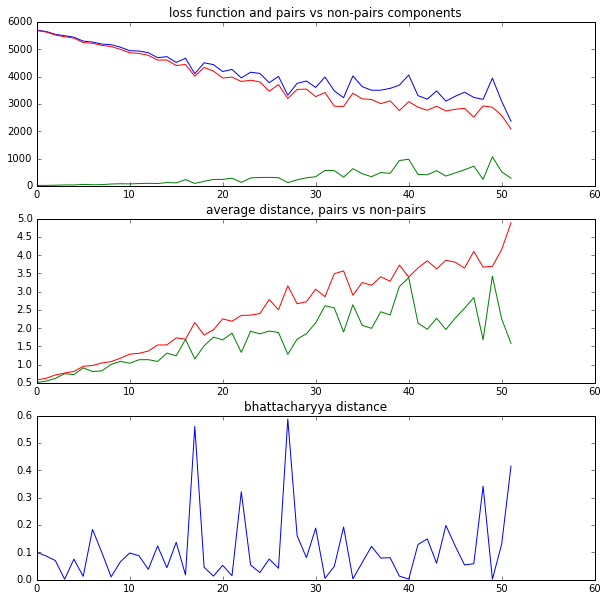

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(train_error_log);
plt.plot(loss_1_log, color='g');
plt.plot(loss_2_log, color='r');
plt.title('loss function and pairs vs non-pairs components');
plt.subplot(312)
plt.plot(d_pairs_log, color='g');
plt.plot(d_non_pairs_log, color='r');
plt.title('average distance, pairs vs non-pairs');
plt.subplot(313)
plt.plot(bhatt_log);
plt.title('bhattacharyya distance');

In [18]:
pair_dists = np.sqrt(squared_dist[np.where(last_labels==1)])
non_pair_dists = np.sqrt(squared_dist[np.where(last_labels==0)])

loss_reconstruct = np.sum(pair_dists**2) + alpha * np.sum(np.max([np.zeros_like(non_pair_dists), m - non_pair_dists], axis=0)**2)
print(loss_reconstruct, train_error_log[-1])

2364.74829102 2364.75


In [19]:
L1 = pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_:batch[2], keep_prob: 1.0})
L2 = non_pair_loss.eval(feed_dict={x_A:batch[0], x_B:batch[1], y_:batch[2], keep_prob: 1.0})
print(L1 + alpha*L2)

3272.45227051


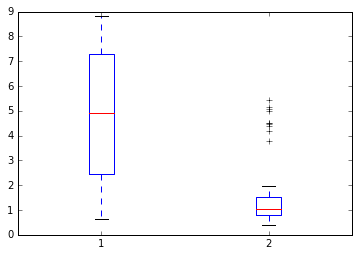

In [20]:
plt.boxplot([non_pair_dists, pair_dists]);

### Test

In [21]:
# subset
test_subset = {uri: test_cliques[uri] for uri in test_cliques.keys()[:128]}

print('Preloading chroma...')
test_uris = util.uris_from_clique_dict(test_subset)
chroma_dict_T = SHS_data.preload_chroma(test_uris)

print('Collecting test dataset...')
X_A_T, X_B_T, is_cover_T, test_pair_uris_T = paired_data.dataset_of_pairs(test_subset, chroma_dict_T,
                                                             n_patches=n_patches, patch_len=patch_len)
print(X_A_T.shape, X_B_T.shape, is_cover_T.shape)

Y_T = is_cover_T.astype(float)

Preloading chroma...
(1266, 512, 12) (1266, 512, 12) (1266,)


  mu_pairs, mu_non_pairs = 1.44, 1.82
bhatt = (0.055340519846046647, 1.436307, 1.8186466)


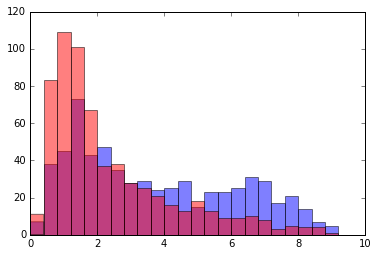

In [22]:
test_squared_dists = squared_error.eval(feed_dict={x_A:X_A_T, x_B:X_B_T, keep_prob: 1.0})
test_squared_dists = np.sum(test_squared_dists, axis=1)

test_pair_dists = np.sqrt(test_squared_dists[np.where(Y_T==1)[0]])
test_non_pair_dists = np.sqrt(test_squared_dists[np.where(Y_T==0)[0]])

bins = np.arange(0,10,0.4)
plt.figure()
plt.hist(test_non_pair_dists, bins=bins, alpha=0.5);
plt.hist(test_pair_dists, bins=bins, color='r', alpha=0.5);

print('bhatt =', approx_bhattacharyya(np.sqrt(test_squared_dists), Y_T))